<a href="https://colab.research.google.com/github/emorrow44/DeepFakeDetection/blob/main/BinaryClassificationGrad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
%%capture
!pip install wandb

In [8]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Imports for augmentations. 
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate
)

In [13]:
## Reference: https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
class GradCAM:
  def __init__(self, model, layerName):
    self.model = model
    self.layerName = layerName
    
    self.gradModel = keras.models.Model(inputs=[self.model.inputs], 
                                        outputs=[self.model.get_layer(self.layerName).output, self.model.output])
    
  def compute_heatmap(self, image, classIdx, eps=1e-8):
    
    with tf.GradientTape() as tape:
      tape.watch(self.gradModel.get_layer(self.layerName).variables)
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = self.gradModel(inputs)

      if len(predictions)==1:
        # Binary Classification
        loss = predictions[0]
      else:
        loss = predictions[:, classIdx]
    
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    
    return heatmap
    
  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_HOT):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
    return (heatmap, output)

In [ ]:
class GRADCamLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, layer_name):
      super(GRADCamLogger, self).__init__()
      self.validation_data = validation_data
      self.layer_name = layer_name

    def on_epoch_end(self, logs, epoch):
      images = []
      grad_cam = []

      ## Initialize GRADCam Class
      cam = GradCAM(model, self.layer_name)

      for image in self.validation_data:
        image = np.expand_dims(image, 0)
        pred = model.predict(image)
        classIDx = np.argmax(pred[0])
  
        ## Compute Heatmap
        heatmap = cam.compute_heatmap(image, classIDx)
        
        image = image.reshape(image.shape[1:])
        image = image*255
        image = image.astype(np.uint8)

        ## Overlay heatmap on original image
        heatmap = cv2.resize(heatmap, (image.shape[0],image.shape[1]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

        images.append(image)
        grad_cam.append(output)

In [14]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [21]:
model = Meso4()
# model.load('/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/Meso4_DF.h5')
model = model.model
#model = model.init_model()
model.load_weights('/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/Meso4_DF.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 8)      32  

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        '/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/more_tests',
        target_size=(256, 256),
        batch_size=1,
        class_mode='binary',
        subset='training')


X, y = generator.next()
orig = X
image = X

## Initialize GRADCam Class
cam = GradCAM(model, "conv2d_11")

#image = np.expand_dims(X, 0)
pred = model.predict(image)
print("Pred: ", pred)
classIDx = np.argmax(pred[0])

## Compute Heatmap
heatmap = cam.compute_heatmap(image, classIDx)

image = image.reshape(image.shape[1:])
image = image*255
image = image.astype(np.uint8)

orig = orig.reshape(orig.shape[1:])
orig = orig*255
orig = orig.astype(np.uint8)

## Overlay heatmap on original image
heatmap = cv2.resize(heatmap, (image.shape[0],image.shape[1]))
(heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)


Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 42ms/step
Pred:  [[0.9697092]]


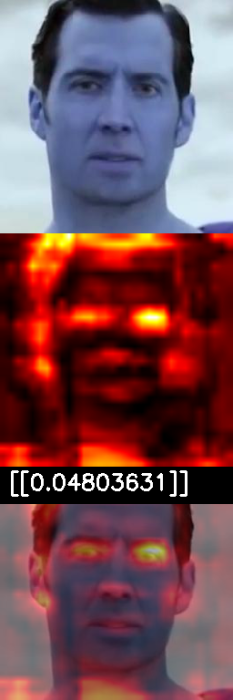

-1

In [44]:
from google.colab.patches import cv2_imshow
import imutils

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, str(pred), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)

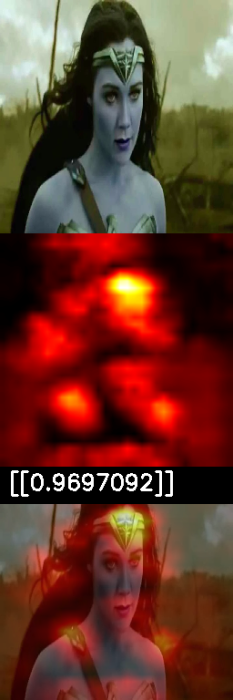

-1

In [47]:
from google.colab.patches import cv2_imshow
import imutils

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, str(pred), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)

In [ ]:
#GRADCamLogger(the X of generator.next, name of last layer "conv2d_15")
